<a href="https://colab.research.google.com/github/TomokazuHonda/data-analysis-basic-kadai/blob/main/%E6%99%82%E7%B3%BB%E5%88%97%E5%88%86%E6%9E%90_P(%E3%83%91%E3%83%A9%E3%83%A1%E3%83%BC%E3%82%BF%E6%9C%80%E9%81%A9%E5%8C%96).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#- 祝日・曜日効果の活用
#add_country_holidays() を使って祝日をモデルに組み込むと精度が上がります。
#- 外部要因の追加
#気温、湿度、感染症の流行指数などを add_regressor() で追加すると、季節性以上の変動も捉えられるようになります。
#- 異常値の処理
#MSEがやや高めなのは、突発的な需要急増（例：パンデミック初期）による外れ値の影響かも。cap や floor を設定して予測範囲を制限するのも有効です。


In [ ]:
import pandas as pd
import seaborn as sns

In [ ]:
#Optunaをインストール
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 18.9 MB/s eta 0:00:00


In [ ]:
import optuna

In [ ]:
# 3. データの準備

In [ ]:
df = pd.read_excel('/content/p-data.xlsx')
df

,日付,A,B
0,2011-01-01,4,4
1,2011-01-02,3,4
2,2011-01-03,5,0
3,2011-01-04,10,6
4,2011-01-05,7,2
...,...,...,...
5321,2025-07-27,0,1
5322,2025-07-28,11,6
5323,2025-07-29,8,6
5324,2025-07-30,7,3


In [ ]:
# データの整形
df_A = df[['日付', 'A']].rename(columns={'日付': 'ds', 'A': 'y'})
df_B = df[['日付', 'B']].rename(columns={'日付': 'ds', 'B': 'y'})

<Axes: xlabel='日付', ylabel='A'>

/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 20184 (\N{CJK UNIFIED IDEOGRAPH-4ED8}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20184 (\N{CJK UNIFIED IDEOGRAPH-4ED8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


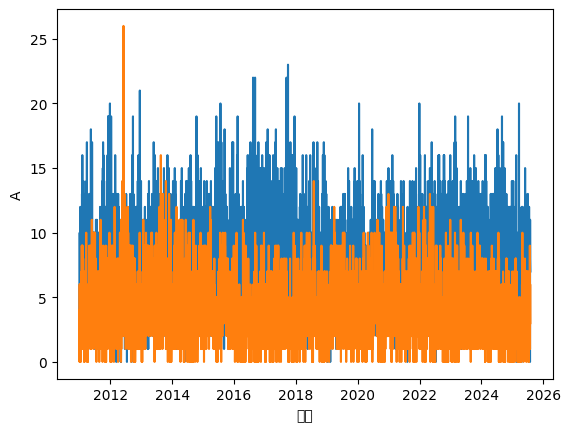

In [ ]:
# 折れ線グラフで可視化
time = pd.to_datetime(df['日付'])
sns.lineplot(x=time, y=df['A'])
sns.lineplot(x=time, y=df['B'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5326 entries, 0 to 5325
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   日付      5326 non-null   datetime64[ns]
 1   A       5326 non-null   int64         
 2   B       5326 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 125.0 KB


In [ ]:
# 4. 予測モデルの学習

In [ ]:
# 引数(seasonality_mode='multiplicative') →周期性変動が徐々に拡大する予測モデル
from prophet import Prophet
## model = Prophet(seasonality_mode='multiplicative')
from prophet.diagnostics import cross_validation, performance_metrics

In [ ]:
# []はリスト
cutoffs = pd.to_datetime(['2019-3-31', '2022-3-31'])

In [ ]:
def objective_A(trial):
    # 試行ごとに変化させたいパラメータをsuggestする
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True)
    seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 0.01, 10, log=True)
    # seasonality_modeは固定でもOKですが、試してみたい場合は以下のようにもできます
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])

    # Prophetモデルをパラメータ付きで定義
    model_A = Prophet(    ##ダブり
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        seasonality_mode=seasonality_mode
    )
    model_A.fit(df_A)   ##ダブり

    # cross-validationでテスト性能を評価
    df_cv_A = cross_validation(model_A, horizon='1096 days', cutoffs=cutoffs, parallel="processes")   ##ダブり
    df_p_A = performance_metrics(df_cv_A)   ##ダブり

    # MAE（平均絶対誤差）を使って評価
    return df_p_A['mae'].mean()

# Optunaで最適化
study_A = optuna.create_study(direction='minimize')
study_A.optimize(objective_A, n_trials=30)  # n_trialsは試行回数


[I 2025-08-28 12:00:35,257] A new study created in memory with name: no-name-481b8cd7-2b0b-4e81-b9d7-8b01a97e307c
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmwgw9mty/vxqtbo7c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmwgw9mty/0hh2ws57.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27732', 'data', 'file=/tmp/tmpmwgw9mty/vxqtbo7c.json', 'init=/tmp/tmpmwgw9mty/0hh2ws57.json', 'output', 'file=/tmp/tmpmwgw9mty/prophet_model3qa8jg91/prophet_model-20250828120035.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:00:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:00:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Applying in par

In [ ]:
def objective_B(trial):
    # 試行ごとに変化させたいパラメータをsuggestする
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True)
    seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 0.01, 10, log=True)
    # seasonality_modeは固定でもOKですが、試してみたい場合は以下のようにもできます
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])

    # Prophetモデルをパラメータ付きで定義
    model_B = Prophet(    ##ダブり
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        seasonality_mode=seasonality_mode
    )
    model_B.fit(df_B)   ##ダブり

    # cross-validationでテスト性能を評価
    df_cv_B = cross_validation(model_B, horizon='1096 days', cutoffs=cutoffs, parallel="processes")   ##ダブり
    df_p_B = performance_metrics(df_cv_B)   ##ダブり

    # MAE（平均絶対誤差）を使って評価
    return df_p_B['mae'].mean()

# Optunaで最適化
study_B = optuna.create_study(direction='minimize')
study_B.optimize(objective_B, n_trials=30)  # n_trialsは試行回数

[I 2025-08-28 12:02:31,753] A new study created in memory with name: no-name-e3256549-c1d6-46fb-9a14-66e59b6bbf60
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmwgw9mty/wzbhaxqb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmwgw9mty/rbu30q_b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39801', 'data', 'file=/tmp/tmpmwgw9mty/wzbhaxqb.json', 'init=/tmp/tmpmwgw9mty/rbu30q_b.json', 'output', 'file=/tmp/tmpmwgw9mty/prophet_modelu_23lu_i/prophet_model-20250828120232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:02:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:02:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Applying in par

In [ ]:
# 最適なパラメータを取得
best_params_A = study_A.best_params
best_params_B = study_B.best_params

# Prophetモデルを再構築
model_A = Prophet(
    changepoint_prior_scale=best_params_A['changepoint_prior_scale'],
    #changepoint_prior_scale=0.5,   #値が小さい程、トレンドは滑らかになり、過去の傾向を重視(推奨:0.001～0.5)
    seasonality_prior_scale=best_params_A['seasonality_prior_scale'],
    seasonality_mode=best_params_A['seasonality_mode'],
    #changepoint_range=0.95  #値が大きいほど、最近のデータに重点を置いて変化点を探す(推奨:0.8～0.95)
)
model_A.fit(df_A)
model_B = Prophet(
    changepoint_prior_scale=best_params_B['changepoint_prior_scale'],
    #changepoint_prior_scale=0.5,   #値が小さい程、トレンドは滑らかになり、過去の傾向を重視(推奨:0.001～0.5)
    seasonality_prior_scale=best_params_B['seasonality_prior_scale'],
    seasonality_mode=best_params_B['seasonality_mode'],
    #changepoint_range=0.95  #値が大きいほど、最近のデータに重点を置いて変化点を探す(推奨:0.8～0.95)
)
model_B.fit(df_B)

# クロスバリデーションと性能評価
df_cv_A = cross_validation(model_A, horizon='1096 days', cutoffs=cutoffs, parallel="processes")
df_p_A = performance_metrics(df_cv_A)
df_cv_B = cross_validation(model_B, horizon='1096 days', cutoffs=cutoffs, parallel="processes")
df_p_B = performance_metrics(df_cv_B)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmwgw9mty/76tj64o4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmwgw9mty/7zg9yfzw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2222', 'data', 'file=/tmp/tmpmwgw9mty/76tj64o4.json', 'init=/tmp/tmpmwgw9mty/7zg9yfzw.json', 'output', 'file=/tmp/tmpmwgw9mty/prophet_model_w3hu3iw/prophet_model-20250828122413.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmwg

In [ ]:
print('ベストパラメータ:', study_A.best_params)
print('ベストパラメータ:', study_B.best_params)


ベストパラメータ: {'changepoint_prior_scale': 0.03307366005359805, 'seasonality_prior_scale': 2.1519568017271733, 'seasonality_mode': 'multiplicative'}
ベストパラメータ: {'changepoint_prior_scale': 0.002053439227277929, 'seasonality_prior_scale': 0.0874264204045565, 'seasonality_mode': 'additive'}


<Axes: xlabel='horizon', ylabel='mse'>

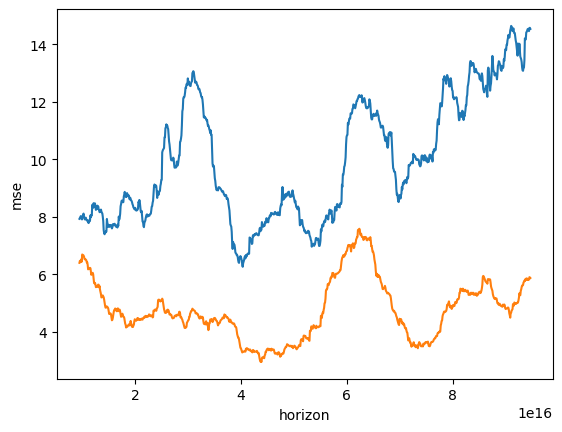

In [ ]:
# プロット
sns.lineplot(x='horizon', y='mse', data=df_p_A)
sns.lineplot(x='horizon', y='mse', data=df_p_B)

<Axes: xlabel='horizon', ylabel='mae'>

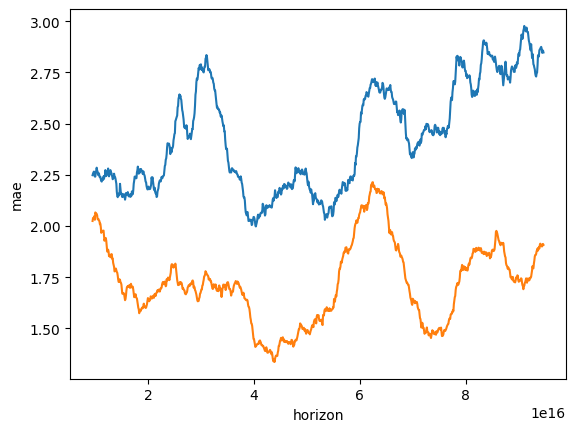

In [ ]:
# プロット
sns.lineplot(x='horizon', y='mae', data=df_p_A)
sns.lineplot(x='horizon', y='mae', data=df_p_B)

In [ ]:
# 5. 予測

In [ ]:
# 予測の事前準備
# 予測したい未来日時を含むDataFrameを作成する必要
# 予測期間を指定してmake_future_dataframeメソッドを実行→未来日時を含むDataFrameの枠組みを作成
#
#  make_future_dataframe(パラメータ)
#  　・periods　予測期間として追加する行数
#　　・freq　　 'D'	 1日
#　　　　　　　 'M'	 1か月（追加される日時データは、月の最終日となる）
#　　　　　     'MS' 1か月（追加される日時データは、月の初日となる）
#　　　　　     'H'	 1時間

future_A = model_A.make_future_dataframe(periods=61, freq='D')
future_B = model_B.make_future_dataframe(periods=61, freq='D')

In [ ]:
forecast_A = model_A.predict(future_A)
forecast_B = model_B.predict(future_B)

In [ ]:
# model.predict 機械学習データが新しいデータに対して予測を行う
forecast_A.tail(61)  #最後の61件だけ表示
forecast_B.tail(61)

# yhat予測値（モデルが予測した値）
# trend  　　 モデルが推定した長期的な傾向
# yhat_lower　予測値の下限（信頼区間の下限）
# yhat_upper  予測値の上限（信頼区間の上限）
# trend_lower トレンドの下限（不確実性含む）
# trend_upper トレンドの上限（不確実性含む）

# trend_lowerとtrend_upperが同じ値→トレンドの不確実性を無視する設定になっている
# 不確実性を含めたい場合は、model = Prophet(uncertainty_samples=1000)に戻してモデルを再構築する


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
5326,2025-08-01,3.702685,2.619434,7.939083,3.702685,3.702685,1.649738,1.649738,1.649738,1.475918,1.475918,1.475918,0.173820,0.173820,0.173820,0.0,0.0,0.0,5.352423
5327,2025-08-02,3.702563,-0.230720,5.187384,3.702563,3.702563,-1.234892,-1.234892,-1.234892,-1.381557,-1.381557,-1.381557,0.146665,0.146665,0.146665,0.0,0.0,0.0,2.467671
5328,2025-08-03,3.702440,-0.558357,4.702903,3.702440,3.702440,-1.578961,-1.578961,-1.578961,-1.696760,-1.696760,-1.696760,0.117799,0.117799,0.117799,0.0,0.0,0.0,2.123479
5329,2025-08-04,3.702318,2.211593,7.935785,3.702318,3.702318,1.279815,1.279815,1.279815,1.191986,1.191986,1.191986,0.087830,0.087830,0.087830,0.0,0.0,0.0,4.982133
5330,2025-08-05,3.702195,1.151674,6.742304,3.702195,3.702195,0.199056,0.199056,0.199056,0.141664,0.141664,0.141664,0.057391,0.057391,0.057391,0.0,0.0,0.0,3.901251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5382,2025-09-26,3.695831,2.495053,8.027074,3.695831,3.695831,1.531094,1.531094,1.531094,1.475918,1.475918,1.475918,0.055175,0.055175,0.055175,0.0,0.0,0.0,5.226925
5383,2025-09-27,3.695709,-0.414988,4.949376,3.695709,3.695709,-1.356880,-1.356880,-1.356880,-1.381557,-1.381557,-1.381557,0.024677,0.024677,0.024677,0.0,0.0,0.0,2.338829
5384,2025-09-28,3.695587,-0.859576,4.862285,3.695587,3.695587,-1.701728,-1.701728,-1.701728,-1.696760,-1.696760,-1.696760,-0.004968,-0.004968,-0.004968,0.0,0.0,0.0,1.993858
5385,2025-09-29,3.695464,2.055158,7.528470,3.695464,3.695464,1.158362,1.158362,1.158362,1.191986,1.191986,1.191986,-0.033624,-0.033624,-0.033624,0.0,0.0,0.0,4.853826


In [ ]:
#A_8m9m = forecast_A.tail(61)
#A_8m9m.to_excel('A_8m9m.xlsx', index=False)
#B_8m9m = forecast_B.tail(61)
#B_8m9m.to_excel('B_8m9m.xlsx', index=False)

In [ ]:
forecast_A[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
# ds	日付
# yhat	予測値
# yhat_lower	予測値の不確実性区間の下限
# yhat_upper	予測値の不確実性区間の上限

,ds,yhat,yhat_lower,yhat_upper
0,2011-01-01,5.142008,1.538058,8.853602
1,2011-01-02,4.824977,1.071447,8.442630
2,2011-01-03,9.291809,5.419116,12.969339
3,2011-01-04,8.099076,4.127710,11.940646
4,2011-01-05,8.571626,4.853770,12.387329
...,...,...,...,...
5382,2025-09-26,10.194315,6.376859,13.798603
5383,2025-09-27,5.325392,1.511153,8.827733
5384,2025-09-28,4.981954,0.967693,8.806298
5385,2025-09-29,9.427373,5.731638,13.256653


In [ ]:
forecast_B[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2011-01-01,2.428977,-0.318011,4.845967
1,2011-01-02,2.048494,-0.697706,4.880301
2,2011-01-03,4.877183,2.271658,7.747233
3,2011-01-04,3.773102,1.259983,6.452809
4,2011-01-05,3.966346,1.090372,6.556203
...,...,...,...,...
5382,2025-09-26,5.226925,2.495053,8.027074
5383,2025-09-27,2.338829,-0.414988,4.949376
5384,2025-09-28,1.993858,-0.859576,4.862285
5385,2025-09-29,4.853826,2.055158,7.528470


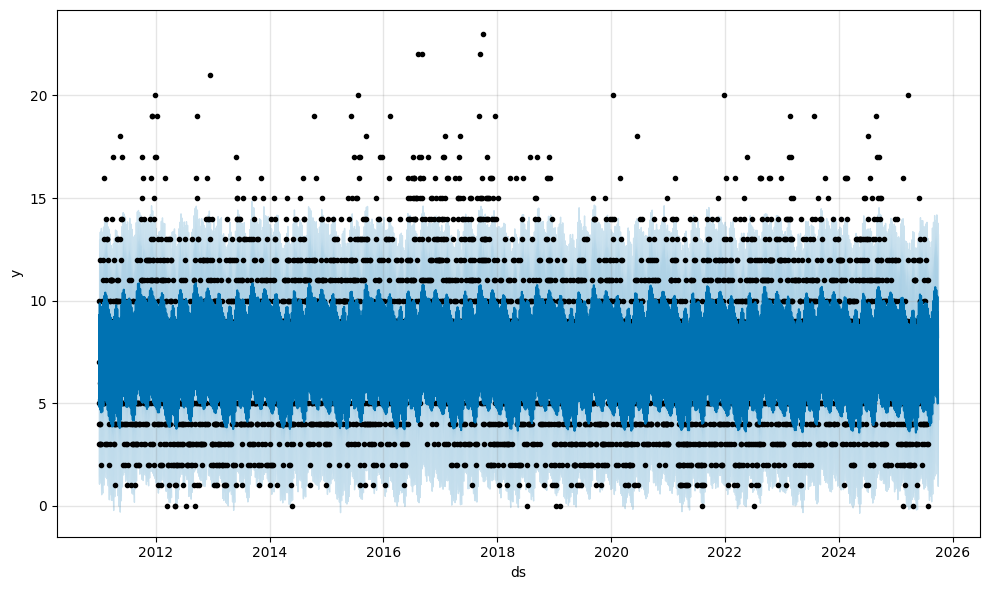

In [ ]:
fig_forecast_A = model_A.plot(forecast_A)
#黒点が実際の値、青ラインが予測モデルによる予測値、水色のエリアが予測値の不確実性区間

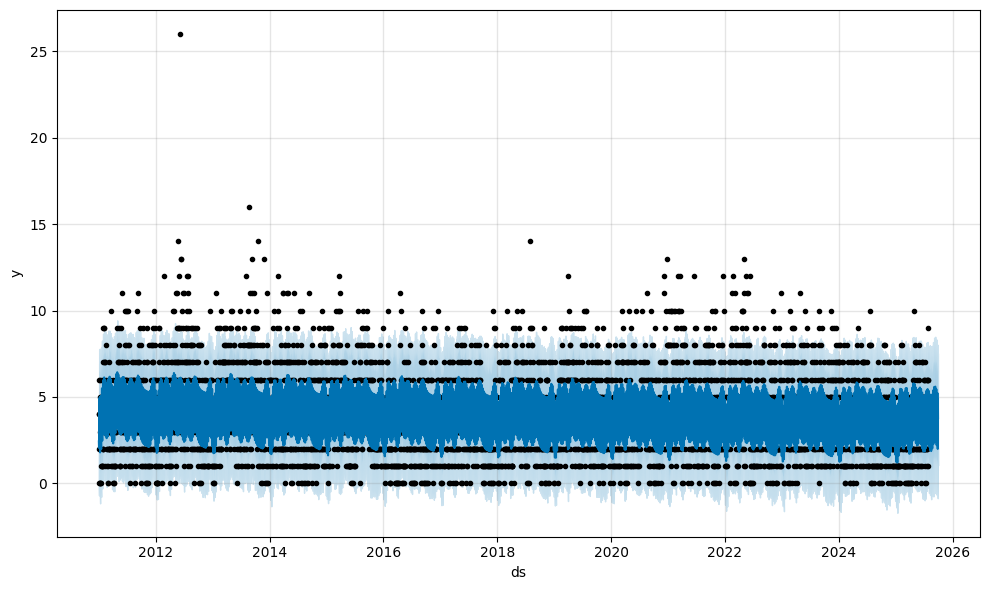

In [ ]:
fig_forecast_B = model_B.plot(forecast_B)
##黒点が実際の値、青ラインが予測モデルによる予測値、水色のエリアが予測値の不確実性区間

In [ ]:
# 6. 予測の評価

In [ ]:
# cutoffs   いつまでのデータを学習データとするかという期限の日付
# horizon   cutoffs翌日以降のテスト期間

In [ ]:
# []はリスト
cutoffs = pd.to_datetime(['2019-3-31', '2022-3-31'])

In [ ]:
# cross_validation関数:交差検証(データを複数回分割して繰り返し評価)
from prophet.diagnostics import cross_validation

In [ ]:
# テスト期間は3年(365×3+1(閏年))
df_cv_A = cross_validation(model_A, horizon = '1096 days', cutoffs=cutoffs)
df_cv_B = cross_validation(model_B, horizon = '1096 days', cutoffs=cutoffs)

  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpmwgw9mty/2rej5xt8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmwgw9mty/bjt34yk0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14607', 'data', 'file=/tmp/tmpmwgw9mty/2rej5xt8.json', 'init=/tmp/tmpmwgw9mty/bjt34yk0.json', 'output', 'file=/tmp/tmpmwgw9mty/prophet_model0s4dqchw/prophet_model-20250828121408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmwgw9mty/r7orcwkh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmwgw9mty/o2mxyoej.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpmwgw9mty/ag13bcrx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmwgw9mty/05kcvrrh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93755', 'data', 'file=/tmp/tmpmwgw9mty/ag13bcrx.json', 'init=/tmp/tmpmwgw9mty/05kcvrrh.json', 'output', 'file=/tmp/tmpmwgw9mty/prophet_modelvvuj0tqh/prophet_model-20250828121410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmwgw9mty/exjfqrni.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmwgw9mty/c2g077p7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [ ]:
df_cv_A

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-04-01,9.804278,5.754702,13.645935,8,2019-03-31
1,2019-04-02,8.619758,4.913937,12.299067,6,2019-03-31
2,2019-04-03,9.061693,5.351025,12.736631,7,2019-03-31
3,2019-04-04,8.022285,4.234038,11.953566,10,2019-03-31
4,2019-04-05,10.451813,6.664827,14.225461,5,2019-03-31
...,...,...,...,...,...,...
2187,2025-03-27,6.008571,2.381065,9.746737,4,2022-03-31
2188,2025-03-28,8.426792,5.324091,12.597434,8,2022-03-31
2189,2025-03-29,3.718493,0.394858,7.320859,2,2022-03-31
2190,2025-03-30,3.477954,-0.427004,7.177719,3,2022-03-31


In [ ]:
# 評価指標を算出
from prophet.diagnostics import performance_metrics

In [ ]:
df_p_A = performance_metrics(df_cv_A)
df_p_B = performance_metrics(df_cv_B)

df_p_A.head()

# mse	     平均二乗誤差(誤差が大きいほど、指標の値も大きい。値が小さいほど良いモデル)
# rmse     二乗平均平方根誤差(〃)
# mae      平均絶対誤差(〃)
# mape     平均絶対パーセント誤差(〃)
# mdape	   メディアン絶対パーセント誤差(〃)
# smape    対称平均絶対パーセント誤差(〃)
# coverage 不確実性区間に予測値が含まれている割合

INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,smape,coverage
0,110 days,9.370343,3.061102,2.472451,0.289040,0.389622,0.757991
1,111 days,9.386359,3.063716,2.476168,0.289040,0.389559,0.757991
2,112 days,9.399211,3.065813,2.478918,0.278194,0.388555,0.757991
3,113 days,9.469907,3.077321,2.488790,0.278194,0.388956,0.753425
4,114 days,9.415078,3.068400,2.480619,0.270362,0.389778,0.755708


<Axes: xlabel='horizon', ylabel='mse'>

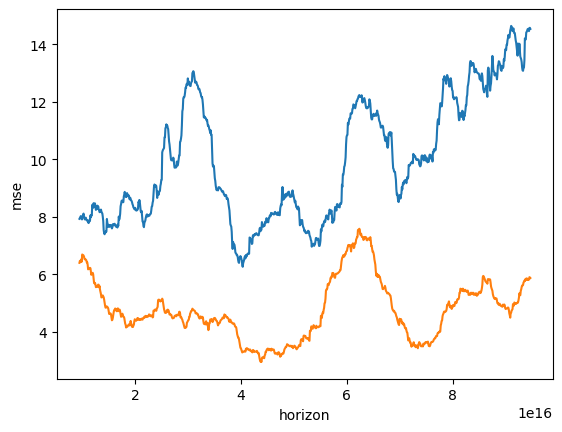

In [ ]:
# 実際の値と予測値の平均二乗誤差であるmseの推移を可視化(horizon:テストデータ区間)
sns.lineplot(x='horizon', y='mse', data=df_p_A)
sns.lineplot(x='horizon', y='mse', data=df_p_B)

<Axes: xlabel='horizon', ylabel='coverage'>

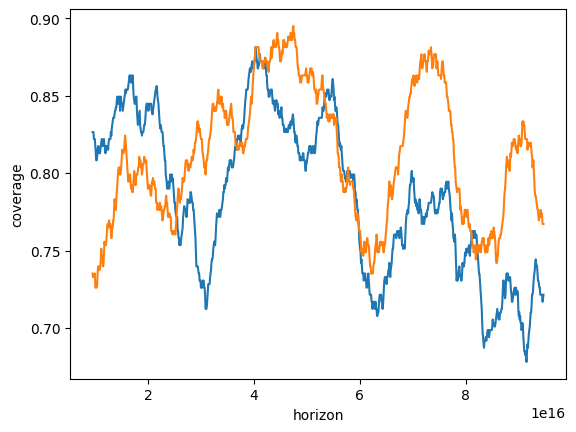

In [ ]:
# 不確実性区間に予測値が含まれている割合であるcoverageを推移を可視化(テストデータ区間)
sns.lineplot(x='horizon', y='coverage', data=df_p_A)
sns.lineplot(x='horizon', y='coverage', data=df_p_B)

In [ ]:
# 補足：予測モデルの構成要素の確認

In [ ]:
print(df_A['ds'].min(), df_A['ds'].max())


2011-01-01 00:00:00 2025-07-31 00:00:00


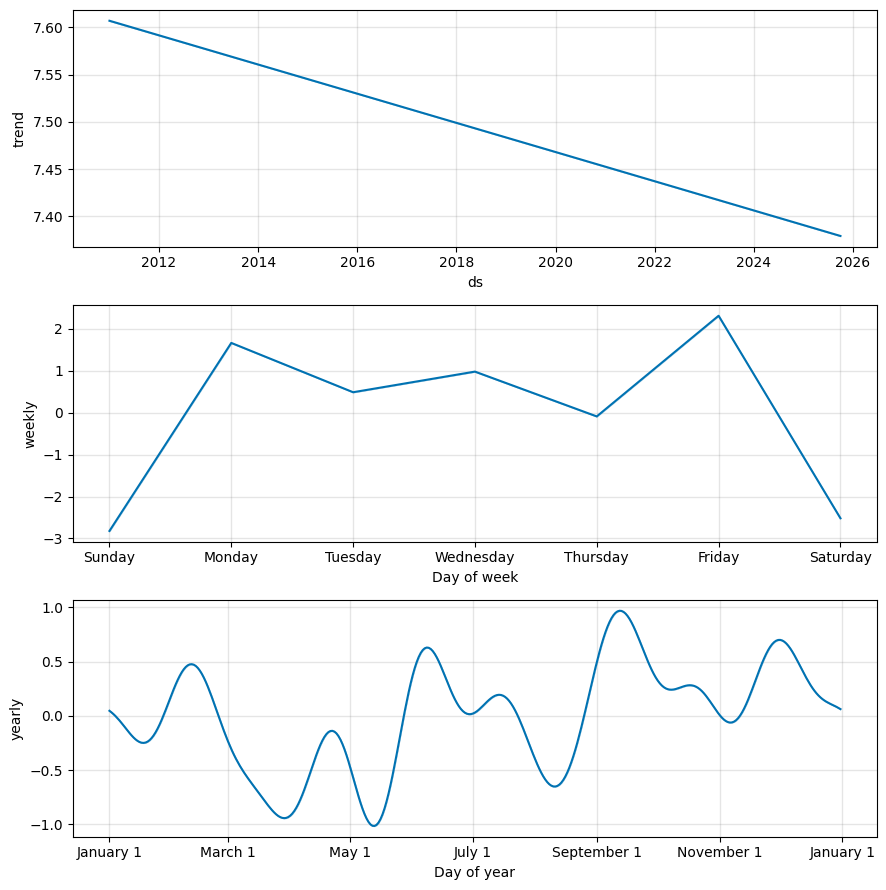

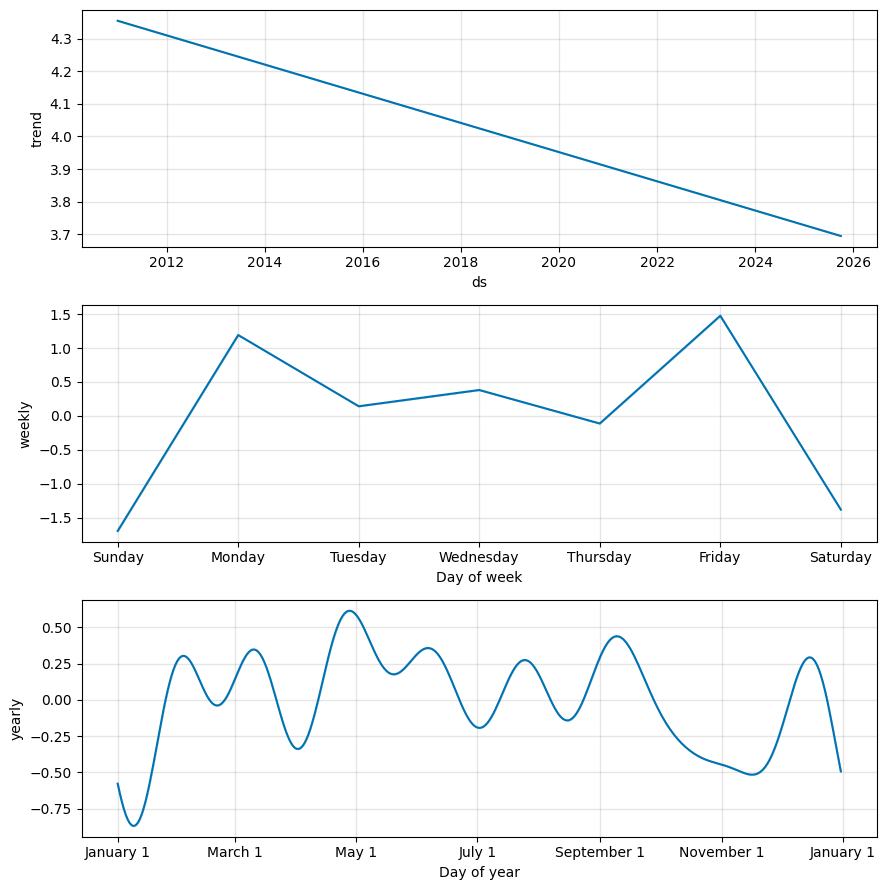

In [ ]:
# 長期トレンド（上側の図）と年間の周期変動（下側の図）
fig_components_A = model_A.plot_components(forecast_A)
fig_components_B = model_B.plot_components(forecast_B)

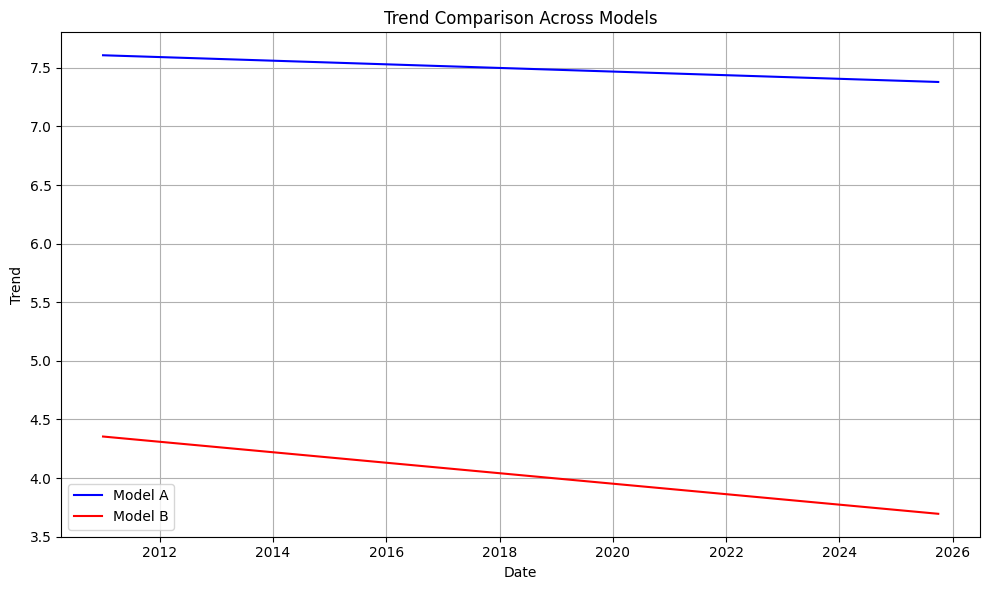

In [ ]:
import matplotlib.pyplot as plt

# 各モデルのトレンド成分を取得
trend_A = forecast_A[['ds', 'trend']]
trend_B = forecast_B[['ds', 'trend']]

# グラフ描画
plt.figure(figsize=(10, 6))
plt.plot(trend_A['ds'], trend_A['trend'], label='Model A', color='blue')
plt.plot(trend_B['ds'], trend_B['trend'], label='Model B', color='red')

plt.title('Trend Comparison Across Models')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
